# Preprocessing of IBG lab wireless data

In [23]:
import time
import pickle
import os
import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sig

import preprocess as pp

%reload_ext autoreload
%autoreload 2

## Setup logging
By defaut, it prints all warning messages to stdout while also recording debug

In [2]:
formatter = logging.Formatter('%(asctime)s %(funcName)5s %(levelname)s: %(message)s')
logFile = 'preprocess log'
# logging.basicConfig(format=form)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('preprocessing.log')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
sh.setFormatter(formatter)
logger.addHandler(sh)

## Setup parameters

In [26]:
# Directory holding the DT2 files
#dataDir = '/home/orel/Data/K6/2020-03-27/WL/'
#dataDir = "D:\\Users\\Matan\\Downloads\\preprocess files test\\"
#dataDir = '/home/ibg/src/Preprocess/DO2/'
dataDir = 'D:\\Katya\\DO5\\10.08.2022-WL\\'

# List of the electrdoe for conversions
#elecList = list(range(2,6))+list(range(7,22))+list(range(23,33))
elecList = list(range(2,33))

# List of files for conversion
fileList = list(range(0,60))

rangeStr = "-F{0}T{1}".format(fileList[0], fileList[-1])

## Plot example of data
The original data is stored in DT2 files - 32ch multiplexed data sampled at 32KHZ

2022-08-10 13:53:08,270 plotWireless INFO: started plotWireless function


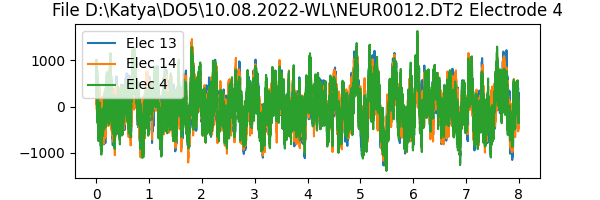

In [28]:
%matplotlib widget

exTimeRange = [0, 8]
exElecs = [13, 14, 4]
exFile = 12

fig, axes = pp.plotWireless(os.path.join(dataDir,f'NEUR{exFile:04d}.DT2'), exTimeRange, exElecs)
fig.set_size_inches((6,2))

# The first tranformation is to continuous binary files separated by channel number

In [29]:
# elecList = list(range(2,15))+[17,18]+list(range(20,32))
# fileList = list(range(0,214))

timeBegin = time.time()
lData = pp.wirelessToBin(dataDir,dataDir + 'binNew/',fileList, elecList, verbose=False)
timeEnd = time.time()
print(f"Converted {len(elecList)} electrodes {lData:,d} samples in {timeEnd-timeBegin:.2f} seconds")

2022-08-10 13:53:49,381 wirelessToBin INFO: started wirelessToBin function


Converted 31 electrodes 15,728,640 samples in 28.91 seconds


2022-08-10 13:54:18,472 plotBin INFO: started plotBin function


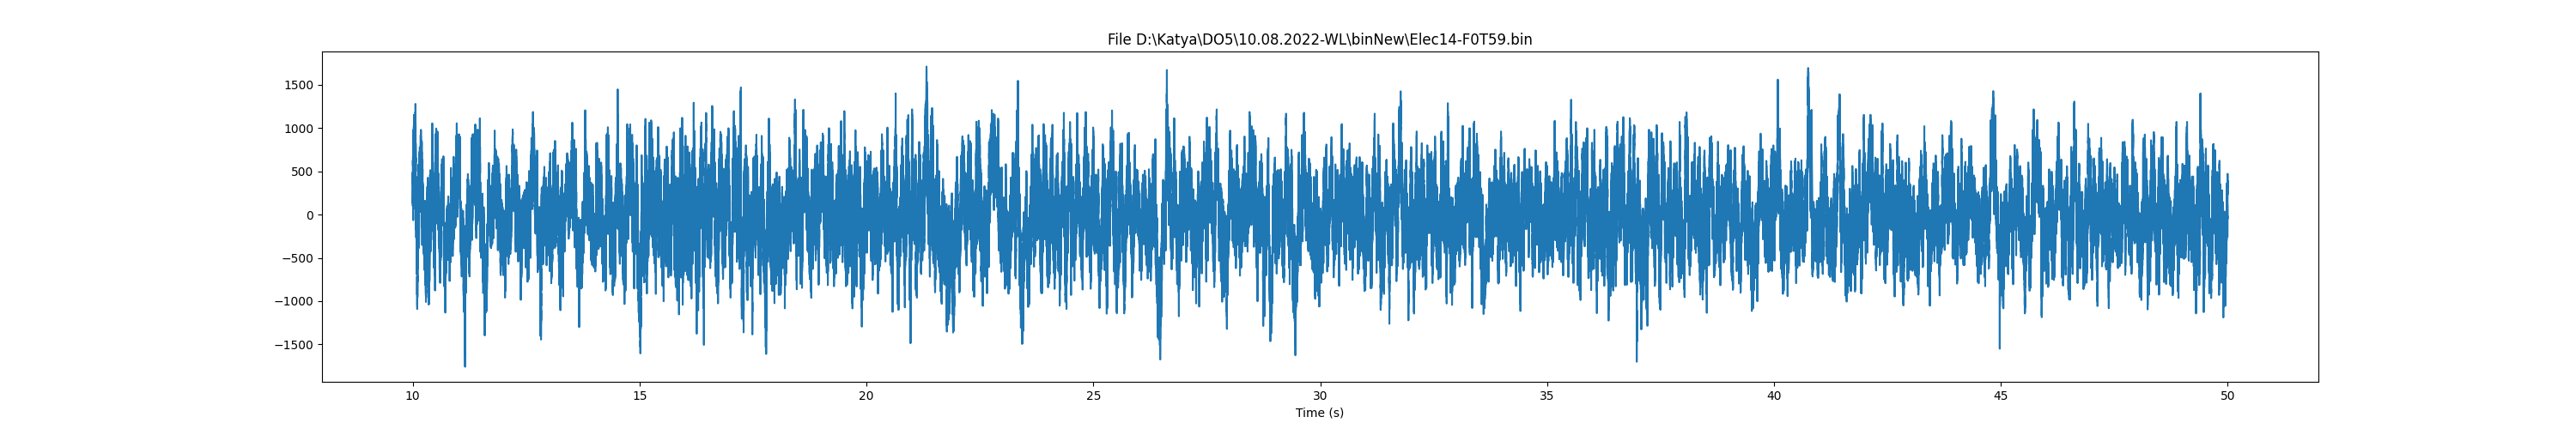

In [30]:
fig, axes = pp.plotBin(os.path.join("D:\\Katya\\DO5\\10.08.2022-WL\\binNew", 'Elec14-F0T59.bin'), [10,50])
fig.set_size_inches((30,5))

# Binary data can be downsampled to 1 KHz and band pass and (opt) notch filtered

In [31]:
timeBegin = time.time()
pp.binToLFP(dataDir+'binNew/', dataDir+'binLFPN/', '{0}Elec{1}' + rangeStr + '.bin', elecList
                    , freq=[2, 300], notch=True, verbose=True)
timeEnd = time.time()
print(f"Downsampled {len(elecList)} electrodes in {timeEnd-timeBegin:.2f} seconds")

2022-08-10 13:54:34,974 binToLFP INFO: started binToLFP function


Tranform binary file D:\Katya\DO5\10.08.2022-WL\binNew/Elec2-F0T59.bin to LFP file D:\Katya\DO5\10.08.2022-WL\binLFPN/Elec2-F0T59.bin
Tranform binary file D:\Katya\DO5\10.08.2022-WL\binNew/Elec3-F0T59.bin to LFP file D:\Katya\DO5\10.08.2022-WL\binLFPN/Elec3-F0T59.bin
Tranform binary file D:\Katya\DO5\10.08.2022-WL\binNew/Elec4-F0T59.bin to LFP file D:\Katya\DO5\10.08.2022-WL\binLFPN/Elec4-F0T59.bin
Tranform binary file D:\Katya\DO5\10.08.2022-WL\binNew/Elec5-F0T59.bin to LFP file D:\Katya\DO5\10.08.2022-WL\binLFPN/Elec5-F0T59.bin
Tranform binary file D:\Katya\DO5\10.08.2022-WL\binNew/Elec6-F0T59.bin to LFP file D:\Katya\DO5\10.08.2022-WL\binLFPN/Elec6-F0T59.bin
Tranform binary file D:\Katya\DO5\10.08.2022-WL\binNew/Elec7-F0T59.bin to LFP file D:\Katya\DO5\10.08.2022-WL\binLFPN/Elec7-F0T59.bin
Tranform binary file D:\Katya\DO5\10.08.2022-WL\binNew/Elec8-F0T59.bin to LFP file D:\Katya\DO5\10.08.2022-WL\binLFPN/Elec8-F0T59.bin
Tranform binary file D:\Katya\DO5\10.08.2022-WL\binNew/Elec9-F

2022-08-10 13:54:46,720 plotBin INFO: started plotBin function


IndexError: index 491520 is out of bounds for axis 0 with size 491520

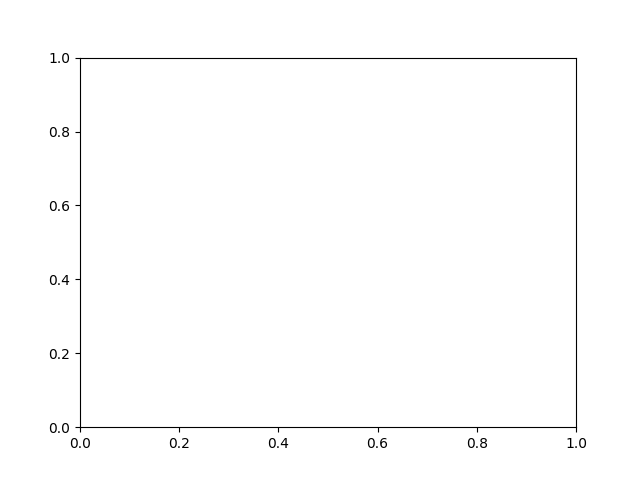

In [32]:
fig, axes = pp.plotBin(dataDir + 'binLFPN/Elec20' + rangeStr+ '.bin', [2, 1000], samplingRate=1000)
fig.set_size_inches((10,5))

# Remove median from the electrodes

In [ ]:
# Remove median from SNr electrodes:
elecList = list(range(2,6))+list(range(7,17))
timeBegin = time.time()
pp.remMedian(os.path.join(dataDir, 'binBand'), os.path.join(dataDir, 'binMed') , elecList, rangeStr, batchSize=1000000, verbose=True)
timeEnd = time.time()
print(f"Remove median for {len(elecList)} in {timeEnd-timeBegin} seconds ")

In [ ]:
# Remove median from Str electrodes:
elecList = list(list(range(17,22))+list(range(23,32)))
timeBegin = time.time()
pp.remMedian(os.path.join(dataDir, 'binBand'), os.path.join(dataDir, 'binMed'), elecList, rangeStr, batchSize=1000000, verbose=True)
timeEnd = time.time()
print(f"Remove median for {len(elecList)} in {timeEnd-timeBegin} seconds ")

In [ ]:
elc = 10
fig, axes = pp.plotBin(os.path.join(dataDir, 'binBand', 'Elec' + str(elc) + rangeStr + '.bin'), [0, 0.5])
fig.set_size_inches((10,5))

# Kinematic data

In [ ]:
# REad kinematic data
df = pp.wirelessToMotion(dataDir, fileList, outDir=os.path.join(dataDir,'binNew'), verbose=False)
logging.info(f'Extract kinematic parameters in {timeEnd-timeBegin:.1f} seconds')
# Remove saturating periods 
df = pp.trimoscillations(df, lp=100)

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4),squeeze=False)

bRange, eRange = 430000, 540000
df = df.astype(float)
# plt.plot(np.sqrt(df['gyr','x'][bRange:eRange]**2+df['gyr','y'][bRange:eRange]**2+df['gyr','z'][bRange:eRange]**2),label='gyrV')
#plt.plot(df['gyr','x'][bRange:eRange],label='gyrX')
# plt.plot(df['gyr','y'][bRange:eRange],label='gyrY')
# plt.plot(df['gyr','z'][bRange:eRange],label='gyrZ')
plt.plot(np.sqrt(df['acc','x'][bRange:eRange]**2+df['acc','y'][bRange:eRange]**2+df['acc','z'][bRange:eRange]**2),label='accV')
plt.plot(df['acc','x'][bRange:eRange],label='accX')
plt.plot(df['acc','y'][bRange:eRange],label='accY')
plt.plot(df['acc','z'][bRange:eRange],label='accZ')
#plt.plot(df['mag','x'][bRange:eRange]*100,label='magX')
plt.legend()
plt.show()

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4),squeeze=False)

f,t,s = sig.spectrogram(df['acc','z'],fs=1000)
ax[0,0].pcolormesh(t, f, np.log(s), shading='gouraud')
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Freq (Hz)');

# May pass high pass filter to remove any remaining low frequencies from the data

In [33]:
#elecList = list(range(2,6))+list(range(7,22))+list(range(23,32))
pp.bandpass_filter(os.path.join(dataDir,'binNew'), os.path.join(dataDir,'binBand'), 'Elec{0}' + rangeStr + '.bin', elecList, freq=[300, 6000])

2022-08-10 13:54:52,725 bandpass_filter INFO: started bandpass filter function


2022-08-10 13:59:59,761 plotBin INFO: started plotBin function


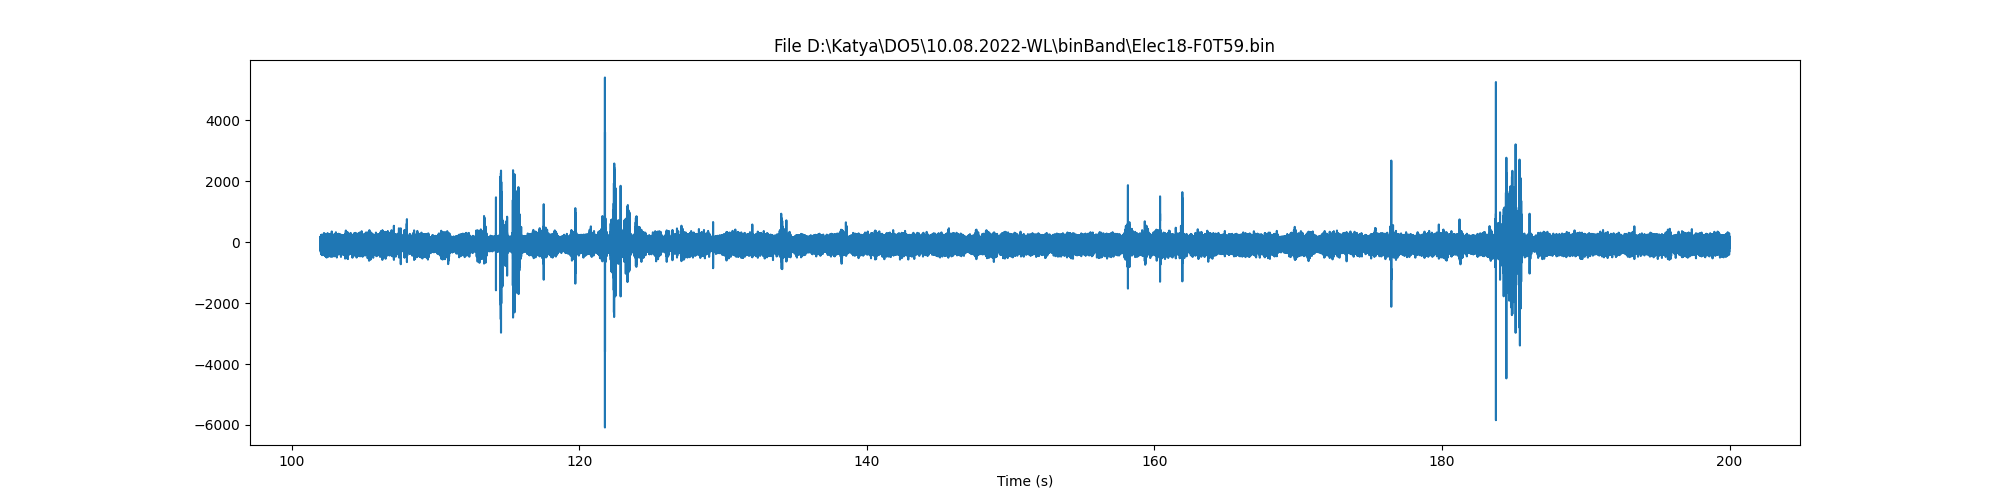

In [41]:
%matplotlib widget
rng = [102,200]
elc = 18

fig, axes = pp.plotBin(os.path.join(dataDir,'binBand','Elec' + str(elc) + rangeStr + '.bin'), rng)
fig.set_size_inches((20,5))

2022-08-10 11:21:39,180 plotBin INFO: started plotBin function
2022-08-10 11:21:39,180 plotBin INFO: started plotBin function


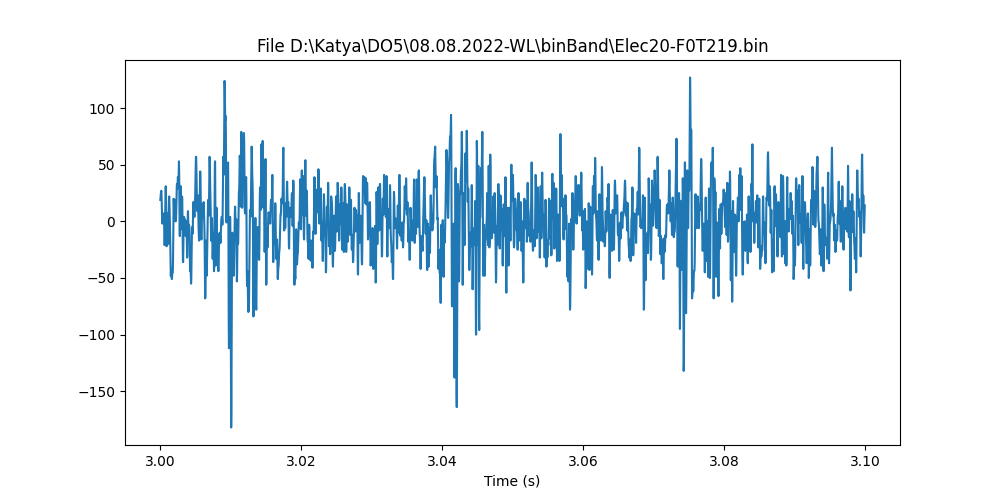

In [28]:
fig, axes = pp.plotBin(os.path.join(dataDir, 'binBand', 'Elec' + str(elc) + rangeStr + '.bin'), rng)
fig.set_size_inches((10,5))